In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

### Splitting dataset into training,validation and test

In [46]:
def build_dataset(words:list):
    '''Seperates the data into training, test and validation'''
    block_size = 8 # Context Length: How many characters we take as input to predict the output 
    X,Y = [],[]
    
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

In [48]:
print(f'Training examples shapes: {Xtr.shape},{Ytr.shape}')
print(f'Validation examples shapes: {Xdev.shape},{Ydev.shape}')
print(f'Testing examples shapes: {Xte.shape},{Yte.shape}')

Training examples shapes: torch.Size([182580, 8]),torch.Size([182580])
Validation examples shapes: torch.Size([22767, 8]),torch.Size([22767])
Testing examples shapes: torch.Size([22799, 8]),torch.Size([22799])


### `PyTorch` code

In [8]:
class Linear:
    def __init__(self,fan_in:int,fan_out:int,bias:bool = True):
        self.weight = torch.randn((fan_in,fan_out),generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias is True else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [84]:
class BatchNormalization:
    def __init__(self,dim,eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters: Trained during Back-Propogation
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Parameters: Updated using running mean and std
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        # Calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
                
            xmean = x.mean(dim,keepdim = True)
            xvar = x.var(dim, keepdim = True, unbiased = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalization to unit variance
        self.out = self.gamma * xhat + self.beta

        # Updating the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma , self.beta]

In [86]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [88]:
class Embedding:
    def __init__(self,num_embedding,embedding_dim):
        self.weights = torch.randn((num_embedding,embedding_dim))

    def __call__(self,ix):
        self.out = self.weights[ix]
        return self.out

    def parameters(self):
        return [self.weights]

In [90]:
class Flatten:
    def __init__(self,n):
        self.n = n
    def __call__(self,x):
        B,T,C = x.shape
        x = x.view(B,T//self.n,C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

In [92]:
class Sequential:
    def __init__(self,layers):
        self.layers = layers

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in  self.layers for p in layer.parameters()]

In [94]:
n_embed = 10
n_hidden = 200
vocab_size = 27
batch_size = 32
max_steps = 200000
block_size = 8
g = torch.Generator().manual_seed(231212121)
C = torch.randn((vocab_size,n_embed))


layers = [
    Embedding(vocab_size,n_embed), Flatten(2),
    Linear(n_embed * 2, n_hidden, bias=False), BatchNormalization(n_hidden), Tanh(),
    Flatten(2),
    Linear(n_hidden * 2, n_hidden, bias=False), BatchNormalization(n_hidden), Tanh(),
    Flatten(2),
    Linear(n_hidden * 2, n_hidden, bias=False), BatchNormalization(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size)
]
model = Sequential(layers)
with torch.no_grad():
    layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()] 
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


In [96]:

losses = []

for i in range(max_steps):
    # Mini-batch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size, ), generator = g)
    Xb,yb = Xtr[ix],Ytr[ix]

    # ----- FORWARD PASS ----- #
    # emb = C[Xb] # Embed the characters into vectors
    # x = emb.view(emb.shape[0],-1) # Reshape the embedding vector into 2-dimensional matrix
    x = Xb
    # for layer in layers:
    #     x = layer(x)
    x = model(x)
    loss = F.cross_entropy(x,yb) # Categorical Cross-Entropy as the loss function

    # ----- BACKWARD PASS ----- #
    # for layer in layers:
    #     layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # ----- UPDATE ----- #
    lr = 0.1 if i < (max_steps // 2) else 0.01
    for p in parameters:
        p.data -= lr * p.grad
        # print(type(p.data),type(p.grad))

    # ----- PRINTING LOSS ----- #
    if (i % 10000 == 0):
        print(f'{i}/{max_steps} -> {loss.item()}')
    losses.append(loss.log10().item())
    # break

0/200000 -> 3.292901039123535
10000/200000 -> 2.767216920852661
20000/200000 -> 1.8124513626098633
30000/200000 -> 2.5276834964752197
40000/200000 -> 1.9392105340957642
50000/200000 -> 1.7606474161148071
60000/200000 -> 2.2816591262817383
70000/200000 -> 2.4296116828918457
80000/200000 -> 1.824960470199585
90000/200000 -> 1.79444420337677
100000/200000 -> 1.7063236236572266
110000/200000 -> 1.9925034046173096
120000/200000 -> 1.9345124959945679
130000/200000 -> 1.7779371738433838
140000/200000 -> 2.090541362762451
150000/200000 -> 1.2573256492614746
160000/200000 -> 1.8015612363815308
170000/200000 -> 1.8979436159133911
180000/200000 -> 1.9834332466125488
190000/200000 -> 1.5732636451721191


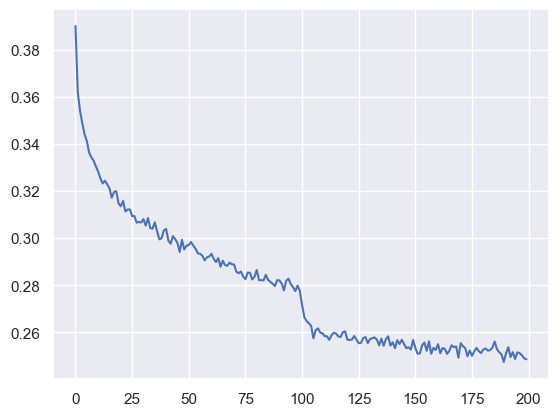

In [97]:
plt.plot(torch.tensor(losses).view(-1,1000).mean(1))

In [98]:
for layer in layers:
    layer.training = False

In [99]:
@torch.no_grad()
def split_loss(split:str):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    # emb = C[x]
    
    # x = emb.view(emb.shape[0],-1)
    # for layer in layers:
    #     x = layer(x)
    x = model(x)
    loss = F.cross_entropy(x,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 1.7600356340408325
val 1.9975627660751343


## Predictions from the model

In [105]:
for layer in model.layers:
    layer.training = False

for _ in range(10):
    out = []
    context = [0]*block_size
    while True:
        # emb = C[torch.tensor([context])]
        # x = emb.view(emb.shape[0],-1)
        # x = torch.tensor([context])
        # for layer in layers:
        #     x = layer(x)
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

tigigley.
azalyn.
jareth.
aruret.
tahan.
adilynn.
aaria.
rowen.
michel.
erick.
